<a href="https://colab.research.google.com/github/cincysam6/Field_Control_Model/blob/improve_functionality/Field_Control_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Magic
# %matplotlib inline

# Utility Libraries
from datetime import datetime
import pytz
from google.colab import files
from scipy.ndimage import gaussian_filter

# HTML
from IPython.display import HTML

# Computation Libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import multivariate_normal, gamma
from scipy.spatial.distance import pdist, squareform

# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.patches import Rectangle, Arrow

from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable, Optional, Tuple

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, gamma


# Graph Libraries
import networkx as nx

from __future__ import annotations

from typing import Any, Dict, List, Optional, Sequence, Tuple, Union
import math



I Import a single play to test this out. Here we have play_id 2617 and gameId 2022092504 from the 2025 Big Data Bowl Competition.

In [35]:
df = pd.read_csv('/content/drive/MyDrive/BDB_Data/pres_example_play.csv')
df.head()

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,team,...,is_off,position,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,y_norm,x_norm,std_x,std_y,player_tags
0,1,2022092504,2617,38632.0,Kirk Cousins,1,BEFORE_SNAP,2022-09-25 19:03:06.2,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.87,1.84,off
1,2,2022092504,2617,38632.0,Kirk Cousins,2,BEFORE_SNAP,2022-09-25 19:03:06.3,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
2,3,2022092504,2617,38632.0,Kirk Cousins,3,BEFORE_SNAP,2022-09-25 19:03:06.4,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
3,4,2022092504,2617,38632.0,Kirk Cousins,4,BEFORE_SNAP,2022-09-25 19:03:06.5,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.85,1.82,off
4,5,2022092504,2617,38632.0,Kirk Cousins,5,BEFORE_SNAP,2022-09-25 19:03:06.6,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.83,1.81,off


In [36]:
#df = pd.read_parquet('/content/drive/MyDrive/BDB_Data/motion_df_for_pitch_control.parquet')


# Filter the DataFrame
filtered_df = df[(df['gameId'] == 2022092504) & (df['playId'] == 2617)]

# Display the filtered DataFrame
print(filtered_df.head())


   Unnamed: 0      gameId  playId    nflId   displayName  frameId  \
0           1  2022092504    2617  38632.0  Kirk Cousins        1   
1           2  2022092504    2617  38632.0  Kirk Cousins        2   
2           3  2022092504    2617  38632.0  Kirk Cousins        3   
3           4  2022092504    2617  38632.0  Kirk Cousins        4   
4           5  2022092504    2617  38632.0  Kirk Cousins        5   

     frameType                   time  jerseyNumber team  ... is_off  \
0  BEFORE_SNAP  2022-09-25 19:03:06.2           8.0  MIN  ...    1.0   
1  BEFORE_SNAP  2022-09-25 19:03:06.3           8.0  MIN  ...    1.0   
2  BEFORE_SNAP  2022-09-25 19:03:06.4           8.0  MIN  ...    1.0   
3  BEFORE_SNAP  2022-09-25 19:03:06.5           8.0  MIN  ...    1.0   
4  BEFORE_SNAP  2022-09-25 19:03:06.6           8.0  MIN  ...    1.0   

   position  pff_defensiveCoverageAssignment  \
0        QB                              NaN   
1        QB                              NaN   
2       

In [37]:
### Selecting a single player ID to test this out
one_player = [40488.0]

In [79]:
single_player = filtered_df[filtered_df['nflId'].isin(one_player)]

In [38]:

# Function to compute distance from the football for a given frame
def compute_distances_by_frame(frame_data):
    # Isolate the football's position within the frame
    football_row = frame_data[frame_data['displayName'] == 'football']
    if football_row.empty:
        # If no football is present in the frame, return NaN for distances
        frame_data['dist_from_football'] = np.nan
    else:
        football_x = football_row['x'].values[0]
        football_y = football_row['y'].values[0]
        # Compute the distance for all players in the frame
        frame_data['dist_from_football'] = np.sqrt((frame_data['x'] - football_x) ** 2 +
                                                   (frame_data['y'] - football_y) ** 2)
    return frame_data

# Apply the function for each frameId group
df = df.groupby('frameId').apply(compute_distances_by_frame)

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Verify results
print(df[['frameId', 'displayName', 'dist_from_football']])

      frameId         displayName  dist_from_football
0           1        Kirk Cousins            6.201815
1           1        Adam Thielen            6.730499
2           1      Charles Harris            2.227667
3           1       Alex Anzalone            3.314362
4           1        Johnny Mundt            5.450616
...       ...                 ...                 ...
4135      180  Christian Darrisaw           20.413538
4136      180        Alim McNeill           24.373954
4137      180           Ed Ingram           22.974850
4138      180   Malcolm Rodriguez            8.990200
4139      180            football            0.000000

[4140 rows x 3 columns]


/tmp/ipython-input-525440378.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('frameId').apply(compute_distances_by_frame)


In [81]:
single_player[['frameId','dir','s','o']]

,frameId,dir,s,o
180,1,21.41,0.55,71.17
181,2,18.70,0.92,68.65
182,3,17.54,1.31,66.92
183,4,16.72,1.67,67.89
184,5,16.06,1.92,66.38
...,...,...,...,...
355,176,76.64,4.65,53.16
356,177,75.23,4.37,53.16
357,178,70.16,4.00,52.15
358,179,61.73,3.70,48.25


In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Iterable, Optional, Tuple, Sequence

def plot_dir_orientation_small_multiples(
    df: pd.DataFrame,
    *,
    frame_ids: Optional[Sequence[int]] = None,
    base_frame: Optional[int] = None,
    offsets: Sequence[int] = (0, 29, 59, 89, 119, 149, 179),
    # columns
    frame_col: str = "frameId",
    x_col: str = "x",
    y_col: str = "y",
    dir_col: str = "dir",   # 0° = north/up, clockwise increasing
    ori_col: str = "o",     # same convention as dir (per your data)
    speed_col: str = "s",   # yards/s (optional, only for arrow scaling)
    # field + styling
    field_x_max: float = 120.0,
    field_y_max: float = 53.3,
    cols: int = 4,
    arrow_len: float = 6.0,         # base arrow length (yards)
    scale_with_speed: bool = True,  # modestly scale arrow by speed
    dir_color: str = "tab:blue",
    ori_color: str = "tab:orange",
    grid_alpha: float = 0.15,
    title_prefix: str = "Dir vs Orientation",
    show: bool = True,
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Small-multiples diagnostic for a *single player's* direction vs orientation.

    Panels show: player's (x, y) and two arrows:
      - dir_col (direction): colored `dir_color`
      - ori_col (orientation): colored `ori_color`

    Angle convention (matches your tracking):
      - 0° = due north (up, +Y)
      - degrees increase clockwise to 360°
      - conversion to matplotlib radians: theta = radians(90 - deg)

    Args
    ----
    df : DataFrame with at least [frame_col, x_col, y_col, dir_col, ori_col].
          Should be a single player's rows (or pre-filtered to one player).
    frame_ids : explicit list of frame IDs to plot (takes precedence if provided).
    base_frame : if provided (and frame_ids is None), build frames as base_frame + offsets.
    offsets : relative offsets from base_frame when frame_ids is None.
    frame_col, x_col, y_col, dir_col, ori_col, speed_col : column names.
    field_x_max, field_y_max : field dimensions in yards.
    cols : number of columns in the subplot grid.
    arrow_len : base arrow length in yards.
    scale_with_speed : if True, multiply arrow length by (0.75 + min(s, 11.3)/22.6).
    dir_color, ori_color : colors for the two arrows.
    grid_alpha : grid transparency.
    title_prefix : figure title prefix.
    show : call plt.show() before returning.

    Returns
    -------
    (fig, axes) : Matplotlib figure and flat array of Axes.
    """
    if frame_ids is None:
        if base_frame is None:
            base_frame = int(df[frame_col].min())
        frame_ids = [base_frame + off for off in offsets]

    frames_available = set(df[frame_col].unique())
    frames_to_plot = [f for f in frame_ids if f in frames_available]
    missing = [f for f in frame_ids if f not in frames_available]
    if not frames_to_plot:
        raise ValueError("None of the requested frames are present in the DataFrame.")
    if missing:
        print(f"Note: skipping missing frames: {missing}")

    def to_theta(deg: float) -> float:
        # Your convention -> matplotlib (0 rad = +X, CCW)
        return np.deg2rad(90.0 - deg)

    n = len(frames_to_plot)
    rows = int(np.ceil(n / cols))
    aspect = field_y_max / field_x_max
    fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 4.5 * rows * aspect))
    axes = np.array(axes).reshape(-1)

    for ax, fid in zip(axes, frames_to_plot):
        row = df.loc[df[frame_col] == fid]
        if row.empty:
            ax.axis("off")
            continue
        r = row.iloc[0]

        x0, y0 = float(r[x_col]), float(r[y_col])
        dir_deg = float(r[dir_col]) if pd.notna(r[dir_col]) else None
        ori_deg = float(r[ori_col]) if pd.notna(r[ori_col]) else None
        spd = float(r[speed_col]) if speed_col in r and pd.notna(r[speed_col]) else 0.0

        # modest speed scaling (keeps arrows readable)
        scale = (0.75 + min(max(spd, 0.0), 11.3) / 22.6) if scale_with_speed else 1.0
        L = arrow_len * scale

        # field + yard lines
        ax.set_xlim(0, field_x_max)
        ax.set_ylim(0, field_y_max)
        for x in range(10, int(field_x_max), 10):
            ax.axvline(x, color="k", lw=1, alpha=0.06)
        ax.scatter(x0, y0, s=60, c="k", zorder=5)

        # draw direction arrow
        if dir_deg is not None:
            th = to_theta(dir_deg)
            ax.arrow(x0, y0, L * np.cos(th), L * np.sin(th),
                     head_width=1.2, head_length=2.0, fc=dir_color, ec=dir_color, lw=1.5, zorder=6)

        # draw orientation arrow
        if ori_deg is not None:
            th_o = to_theta(ori_deg)
            ax.arrow(x0, y0, L * np.cos(th_o), L * np.sin(th_o),
                     head_width=1.2, head_length=2.0, fc=ori_color, ec=ori_color, lw=1.5, alpha=0.8, zorder=6)

        # panel title with exact values
        t_dir = f"{dir_deg:.2f}°" if dir_deg is not None else "NA"
        t_ori = f"{ori_deg:.2f}°" if ori_deg is not None else "NA"
        ax.set_title(f"Frame {fid}  |  dir={t_dir}  |  o={t_ori}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(alpha=grid_alpha)

    # turn off any extra axes
    for ax in axes[n:]:
        ax.axis("off")

    fig.suptitle(f"{title_prefix}: direction vs orientation (player small multiples)", fontsize=14)
    fig.tight_layout(rect=[0, 0.02, 1, 0.95])

    if show:
        plt.show()
    return fig, axes


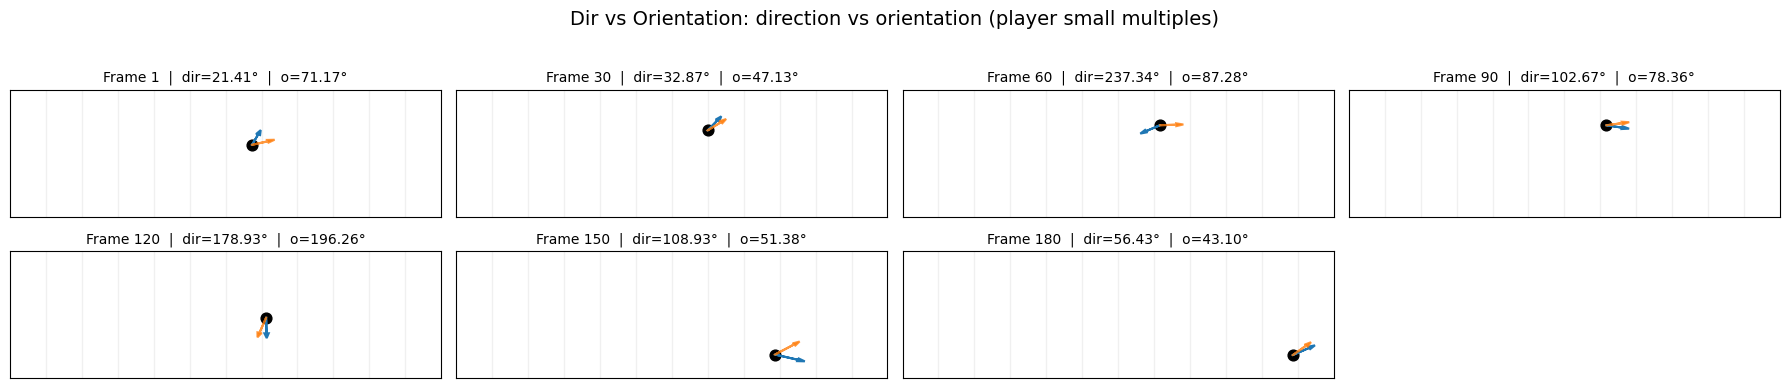

(<Figure size 1800x399.75 with 8 Axes>,
 array([<Axes: title={'center': 'Frame 1  |  dir=21.41°  |  o=71.17°'}>,
        <Axes: title={'center': 'Frame 30  |  dir=32.87°  |  o=47.13°'}>,
        <Axes: title={'center': 'Frame 60  |  dir=237.34°  |  o=87.28°'}>,
        <Axes: title={'center': 'Frame 90  |  dir=102.67°  |  o=78.36°'}>,
        <Axes: title={'center': 'Frame 120  |  dir=178.93°  |  o=196.26°'}>,
        <Axes: title={'center': 'Frame 150  |  dir=108.93°  |  o=51.38°'}>,
        <Axes: title={'center': 'Frame 180  |  dir=56.43°  |  o=43.10°'}>,
        <Axes: >], dtype=object))

In [95]:
plot_dir_orientation_small_multiples(single_player)

In [94]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable, Optional, Tuple

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, gamma


@dataclass(frozen=True)
class Grid:
    """Immutable container for the field grid."""
    X: np.ndarray  # shape (ny, nx)
    Y: np.ndarray  # shape (ny, nx)

    @property
    def x_vals(self) -> np.ndarray:
        return self.X[0, :]

    @property
    def y_vals(self) -> np.ndarray:
        return self.Y[:, 0]


class PlayerInfluenceModel:
    """
    Player influence density model (Gaussian + Gamma mix) with tunable controls.

    Angle convention (tracking data):
      - 0° = due north (+Y)
      - degrees increase clockwise to 360°
    Mapping to math/Matplotlib:
      - 0 rad = +X, CCW positive
      - theta = radians(90 - deg)     ← single, canonical conversion
    """

    def __init__(
        self,
        grid_x_res: int = 200,
        grid_y_res: int = 100,
        field_x_max: float = 120.0,
        field_y_max: float = 53.3,
        *,
        # Keep as a knob but OFF by default; only used if apply_bias=True is requested
        orientation_bias_deg: float = 0.0,
        # Gaussian controls
        gaussian_scale_factor: float = 0.7,
        # Gamma controls
        alpha_gamma: float = 11.0,
        beta_min: float = 1.0,
        beta_max: float = 20.0,
        gamma_midpoint: float = 15.0,
        gamma_scale_factor: float = 0.8,
        max_forward_distance: float = 20.0,
        forward_decay_factor: float = 1.0,
        # Angular cone
        angle_limit_min: float = 15.0,
        angle_limit_max: float = 45.0,
        angle_decay_factor: float = 2.0,
        # Mixture weights
        w_gaussian_min: float = 0.2,
        w_gaussian_max: float = 1.0,
        gaussian_midpoint: float = 4.0,
        gaussian_steepness: float = 2.0,
    ) -> None:
        # --- grid / field ---
        self.grid_x_res = int(grid_x_res)
        self.grid_y_res = int(grid_y_res)
        self.field_x_max = float(field_x_max)
        self.field_y_max = float(field_y_max)

        x_vals = np.linspace(0.0, self.field_x_max, self.grid_x_res)
        y_vals = np.linspace(0.0, self.field_y_max, self.grid_y_res)
        X, Y = np.meshgrid(x_vals, y_vals)
        self.grid = Grid(X=X, Y=Y)

        # Tunables
        self.orientation_bias_deg = float(orientation_bias_deg)
        self.gaussian_scale_factor = float(gaussian_scale_factor)

        self.alpha_gamma = float(alpha_gamma)
        self.beta_min = float(beta_min)
        self.beta_max = float(beta_max)
        self.gamma_midpoint = float(gamma_midpoint)
        self.gamma_scale_factor = float(gamma_scale_factor)
        self.max_forward_distance = float(max_forward_distance)
        self.forward_decay_factor = float(forward_decay_factor)

        self.angle_limit_min = float(angle_limit_min)
        self.angle_limit_max = float(angle_limit_max)
        self.angle_decay_factor = float(angle_decay_factor)

        self.w_gaussian_min = float(w_gaussian_min)
        self.w_gaussian_max = float(w_gaussian_max)
        self.gaussian_midpoint = float(gaussian_midpoint)
        self.gaussian_steepness = float(gaussian_steepness)

    # ------------------ Angle helpers (single source of truth) ------------------ #
    @staticmethod
    def _norm_deg(deg: float) -> float:
        """Normalize degrees to [0, 360)."""
        return (deg % 360.0 + 360.0) % 360.0

    def theta_from_tracking(self, deg: float, *, apply_bias: bool = False) -> float:
        """
        Convert tracking angle (0°=north, clockwise) → radians (0 rad = +X, CCW).

        theta = radians(90 - deg [+ orientation_bias_deg if apply_bias])
        """
        eff_deg = 90.0 - deg + (self.orientation_bias_deg if apply_bias else 0.0)
        return np.deg2rad(self._norm_deg(eff_deg))

    # ------------------ Mixture weights ------------------ #
    def dynamic_weights(self, speed: float) -> Tuple[float, float]:
        """Return (wG, wH) where wH = 1 - wG; wG decreases with speed."""
        wG = self.w_gaussian_min + (self.w_gaussian_max - self.w_gaussian_min) / (
            1.0 + np.exp(self.gaussian_steepness * (speed - self.gaussian_midpoint))
        )
        return float(wG), float(1.0 - wG)

    # ------------------ Gaussian component ------------------ #
    @staticmethod
    def _radius_influence(dist_from_ball: float) -> float:
        """Baseline radius as a function of ball distance; capped after ~18 yds."""
        if dist_from_ball <= 18.0:
            return 1.0 + (3.0 / (18.0 ** 2)) * (dist_from_ball ** 2)
        return 3.0

    def _sigma(
        self,
        theta: float,
        speed: float,
        dist_from_ball: float,
        *,
        max_speed: float = 11.3,
    ) -> np.ndarray:
        """Rotated 2×2 covariance; elongates along θ with speed; shrinks cross‑θ."""
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        ratio = float((speed ** 2) / (max_speed ** 2))
        base = self._radius_influence(dist_from_ball)
        sx = (base + base * ratio) * self.gaussian_scale_factor   # along-θ
        sy = max((base - base * ratio) * self.gaussian_scale_factor, sx * 0.5)  # cross-θ
        S = np.array([[sx, 0.0], [0.0, sy]])
        cov = R @ (S ** 2) @ R.T
        cov += np.eye(2) * 1e-6
        return cov

    @staticmethod
    def _mu(pos_xy: Tuple[float, float], vel_xy: np.ndarray) -> np.ndarray:
        """Gaussian mean at position nudged by 0.5 * velocity."""
        return np.array(pos_xy, dtype=float) + 0.5 * vel_xy

    # ------------------ Gamma anchor point ------------------ #
    def compute_offset(self, pos_xy: Tuple[float, float], direction_deg: float, speed: float) -> Tuple[float, float]:
        """
        Put gamma's reference point slightly *behind* the player so its mode falls near the player.
        """
        beta = self.beta_min + (self.beta_max - self.beta_min) / (1.0 + np.exp(1.0 * (speed - 1.0)))
        mode = (8.0 - 1.0) / beta
        th = self.theta_from_tracking(direction_deg, apply_bias=False)
        return (pos_xy[0] - mode * np.cos(th), pos_xy[1] - mode * np.sin(th))

    # ------------------ Core density ------------------ #
    def base_distribution(
        self,
        pos_xy: Tuple[float, float],
        pos_off_xy: Tuple[float, float],
        direction_deg: float,
        speed: float,
        *,
        dist_from_ball: float,
        alpha_gamma: Optional[float] = None,
    ) -> np.ndarray:
        """
        Mixed influence Z = wG * Gaussian + wH * Gamma, both normalized to [0,1] before mixing.
        """
        X, Y = self.grid.X, self.grid.Y
        x_off, y_off = pos_off_xy
        th = self.theta_from_tracking(direction_deg, apply_bias=False)

        vel = np.array([np.cos(th) * speed, np.sin(th) * speed], dtype=float)

        # Cone width narrows with speed
        ang_lim_deg = self.angle_limit_min + (self.angle_limit_max - self.angle_limit_min) * np.exp(
            -speed / self.angle_decay_factor
        )

        # Gaussian
        cov = self._sigma(th, speed, dist_from_ball)
        mu = self._mu(pos_xy, vel)
        G = multivariate_normal(mean=mu, cov=cov).pdf(np.dstack((X, Y)))
        G /= G.max() if G.max() > 0 else 1.0

        # Gamma (forward projection)
        beta_dyn = self.beta_min + (self.beta_max - self.beta_min) * (speed / self.gamma_midpoint)
        beta_dyn = np.clip(beta_dyn, self.beta_min, self.beta_max)

        dx, dy = X - x_off, Y - y_off
        d_proj = dx * np.cos(th) + dy * np.sin(th)
        d_scaled = d_proj / max(speed * (1.0 + speed / 18.0), 1e-3)

        a = float(self.alpha_gamma if alpha_gamma is None else alpha_gamma)
        H = gamma.pdf(d_scaled, a=a, scale=1.0 / (beta_dyn * self.gamma_scale_factor))

        # Fade after forward cap
        mask_far = d_proj > self.max_forward_distance
        if np.any(mask_far):
            fade = self.forward_decay_factor if self.forward_decay_factor > 0 else 1.0
            H[mask_far] *= np.exp(-((d_proj[mask_far] - self.max_forward_distance) ** 2) / (2.0 * (speed * fade) ** 2 + 1e-6))

        # Angular soft gate around θ
        ang_to_pt = np.arctan2(dy, dx)
        ang_diff = np.abs((ang_to_pt - th + np.pi) % (2.0 * np.pi) - np.pi)
        H *= 1.0 / (1.0 + np.exp(10.0 * (ang_diff - np.radians(ang_lim_deg))))
        H /= H.max() if H.max() > 0 else 1.0

        # Mix
        wG, wH = self.dynamic_weights(speed)
        Z = wG * G + wH * H
        return Z

    # ------------------ Batch per frame ------------------ #
    def compute_influence(
        self,
        df: pd.DataFrame,
        frame_id: int,
        player_ids: Optional[Iterable[int]] = None,
        *,
        id_col: str = "nflId",
        name_col: str = "displayName",
        x_col: str = "x",
        y_col: str = "y",
        speed_col: str = "s",
        dir_col: str = "dir",
        dist_from_ball_col: str = "dist_from_football",
        density_out_col: str = "density_grid",
    ) -> pd.DataFrame:
        """Compute per‑player grids for one frame."""
        f = df.loc[df["frameId"] == frame_id].copy()
        if player_ids is not None:
            if isinstance(player_ids, (int, float, str)):
                player_ids = [player_ids]
            f = f[f[id_col].isin(player_ids)].copy()
        if name_col in f.columns:
            f = f[f[name_col].str.lower() != "football"].copy()

        required = {id_col, x_col, y_col, speed_col, dir_col, dist_from_ball_col}
        missing = required - set(f.columns)
        if missing:
            raise KeyError(f"Missing required columns in df: {sorted(missing)}")

        out_rows = []
        for _, r in f.iterrows():
            pos = (float(r[x_col]), float(r[y_col]))
            dir_deg = float(r[dir_col])
            spd = float(r[speed_col])
            dball = float(r[dist_from_ball_col])

            pos_off = self.compute_offset(pos, dir_deg, spd)
            Z = self.base_distribution(
                pos_xy=pos,
                pos_off_xy=pos_off,
                direction_deg=dir_deg,
                speed=spd,
                dist_from_ball=dball,
            )
            rec = r.to_dict()
            rec[density_out_col] = Z
            out_rows.append(rec)

        return pd.DataFrame(out_rows)


In [97]:
from __future__ import annotations

from typing import Iterable, List, Optional, Sequence, Tuple, Union
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D


def diagnostic_plot(
    df: pd.DataFrame,
    frame_id: int,
    player_ids: Optional[Union[int, Sequence[int]]] = None,
    *,
    # Player speeds to plot — tuple/list of numbers OR ('actual',)
    speeds: Union[Sequence[float], Tuple[str, ...]] = (1.0, 5.0, 10.0),

    # Influence model settings
    grid_x_res: int = 200,
    grid_y_res: int = 100,
    field_x_max: float = 120.0,
    field_y_max: float = 53.3,
    orientation_bias_deg: float = 0.0,   # no extra bias by default

    # Gaussian / Gamma parameters
    sigma_gaussian: float = 5.0,         # deprecated (ignored)
    gaussian_scale_factor: float = 0.7,
    w_gaussian_max: float = 1.0,
    gaussian_midpoint: float = 4.0,
    gaussian_steepness: float = 2.0,
    alpha_gamma: float = 11.0,
    beta_min: float = 1.0,
    beta_max: float = 20.0,
    gamma_midpoint: float = 15.0,
    gamma_scale_factor: float = 0.8,
    max_forward_distance: float = 20.0,
    forward_decay_factor: float = 1.0,

    # Angular filtering
    angle_limit_min: float = 15.0,
    angle_limit_max: float = 45.0,
    angle_decay_factor: float = 2.0,

    # Mixture weights
    w_gaussian_min: float = 0.2,

    # Plot style
    contour_levels: int = 20,
    cmap: str = "Reds",
    alpha: float = 0.30,
    arrow_scale: float = 5.0,
    arrow_head_width: float = 1.0,
    arrow_head_length: float = 2.0,
    zoom_x_range: float = 10.0,
    ylim: Optional[Tuple[float, float]] = (0.0, 53.0),
    grid_alpha: float = 0.20,

    # Direction vs Orientation arrow styles
    dir_color: str = "tab:blue",
    ori_color: str = "tab:orange",
    draw_orientation: bool = True,

    # Behavior
    show: bool = True,
    return_fig: bool = False,

    # Column names
    x_col: str = "x",
    y_col: str = "y",
    dir_col: str = "dir",     # 0°=north, clockwise
    ori_col: str = "o",       # orientation; same convention as dir
    speed_col: str = "s",     # yd/s
    dist_from_ball_col: str = "dist_from_football",
    name_col: str = "displayName",
) -> Optional[List[plt.Figure]]:
    """
    Per-player diagnostic: plot mixed influence (Gaussian+Gamma) and overlay two arrows:
      - Direction (`dir_col`) in `dir_color`
      - Orientation (`ori_col`) in `ori_color` (if present and `draw_orientation=True`)

    Angles use the SAME converter as the class:
        theta = model.theta_from_tracking(deg, apply_bias=False)
    """
    # Ensure model exists
    try:
        PlayerInfluenceModel  # type: ignore[name-defined]
    except NameError as e:
        raise NameError("PlayerInfluenceModel must be defined/imported before calling diagnostic_plot().") from e

    if sigma_gaussian is not None:
        warnings.warn(
            "diagnostic_plot: `sigma_gaussian` is deprecated and ignored by the current model.",
            DeprecationWarning,
            stacklevel=2,
        )

    # Build model
    model = PlayerInfluenceModel(
        grid_x_res=grid_x_res,
        grid_y_res=grid_y_res,
        field_x_max=field_x_max,
        field_y_max=field_y_max,
        orientation_bias_deg=orientation_bias_deg,  # defaults to 0.0 now
        gaussian_scale_factor=gaussian_scale_factor,
        alpha_gamma=alpha_gamma,
        beta_min=beta_min,
        beta_max=beta_max,
        gamma_midpoint=gamma_midpoint,
        gamma_scale_factor=gamma_scale_factor,
        max_forward_distance=max_forward_distance,
        forward_decay_factor=forward_decay_factor,
        angle_limit_min=angle_limit_min,
        angle_limit_max=angle_limit_max,
        angle_decay_factor=angle_decay_factor,
        w_gaussian_min=w_gaussian_min,
        w_gaussian_max=w_gaussian_max,
        gaussian_midpoint=gaussian_midpoint,
        gaussian_steepness=gaussian_steepness,
    )

    # Get per-player rows for the frame (we'll recompute Z for chosen speeds)
    influence_df = model.compute_influence(
        df=df,
        frame_id=frame_id,
        player_ids=player_ids,
        x_col=x_col,
        y_col=y_col,
        dir_col=dir_col,
        speed_col=speed_col,
        dist_from_ball_col=dist_from_ball_col,
        density_out_col="__ignored__",
    )

    X, Y = model.grid.X, model.grid.Y
    figs: List[plt.Figure] = []

    use_actual = (
        (isinstance(speeds, (list, tuple)) and len(speeds) == 1 and speeds[0] == "actual")
        or speeds == ("actual",)
    )

    # Legend proxies for arrows
    legend_elems = [
        Line2D([0], [0], color=dir_color, lw=2, label="Direction"),
        Line2D([0], [0], color=ori_color, lw=2, label="Orientation"),
    ]

    for _, row in influence_df.iterrows():
        player_pos = (float(row[x_col]), float(row[y_col]))
        player_dir_deg = float(row[dir_col])
        dist_from_football = float(row[dist_from_ball_col])
        display_name = str(row.get(name_col, "Player"))

        if use_actual:
            speed_list: List[float] = [float(row[speed_col])]
        else:
            speed_list = [float(s) for s in speeds]  # type: ignore[arg-type]

        # Try to fetch orientation if present
        has_ori = draw_orientation and (ori_col in df.columns or ori_col in row.index)
        player_ori_deg = None
        if has_ori and pd.notna(row.get(ori_col, np.nan)):
            player_ori_deg = float(row[ori_col])

        for spd in speed_list:
            pos_offset = model.compute_offset(player_pos, player_dir_deg, spd)

            Z = model.base_distribution(
                pos_xy=player_pos,
                pos_off_xy=pos_offset,
                direction_deg=player_dir_deg,
                speed=spd,
                dist_from_ball=dist_from_football,
                alpha_gamma=alpha_gamma,
            )

            fig = plt.figure(figsize=(10, 7))
            plt.contourf(X, Y, Z, levels=contour_levels, cmap=cmap, alpha=alpha)

            # Player marker
            plt.scatter(player_pos[0], player_pos[1], c="blue", edgecolor="black", s=100, zorder=5)

            # Direction arrow (uses the class's converter)
            th_dir = model.theta_from_tracking(player_dir_deg, apply_bias=False)
            arrow_len = (spd / 11.3) * arrow_scale
            plt.arrow(
                player_pos[0], player_pos[1],
                arrow_len * np.cos(th_dir), arrow_len * np.sin(th_dir),
                head_width=arrow_head_width, head_length=arrow_head_length,
                fc=dir_color, ec=dir_color, zorder=6
            )

            # Orientation arrow (optional, same converter)
            if player_ori_deg is not None:
                th_ori = model.theta_from_tracking(player_ori_deg, apply_bias=False)
                ori_len = arrow_len * 0.9
                plt.arrow(
                    player_pos[0], player_pos[1],
                    ori_len * np.cos(th_ori), ori_len * np.sin(th_ori),
                    head_width=arrow_head_width, head_length=arrow_head_length,
                    fc=ori_color, ec=ori_color, alpha=0.9, zorder=6
                )

            # Title shows both angles if available
            speed_str = f"{spd:.2f} yd/s" if not use_actual else f"{float(row[speed_col]):.2f} yd/s"
            if player_ori_deg is not None:
                title_str = f"{display_name} – Speed={speed_str} | dir={player_dir_deg:.2f}° | o={player_ori_deg:.2f}°"
            else:
                title_str = f"{display_name} – Speed={speed_str} | dir={player_dir_deg:.2f}°"

            plt.title(title_str)
            plt.xlabel("X (yards)")
            plt.ylabel("Y (yards)")
            plt.grid(alpha=grid_alpha)

            # Zoom view
            plt.xlim(player_pos[0] - zoom_x_range, player_pos[0] + zoom_x_range)
            if ylim is not None:
                plt.ylim(*ylim)

            # Add arrow legend once (top-left outside plot)
            if player_ori_deg is not None:
                plt.legend(handles=legend_elems, loc="upper left")

            if show:
                plt.show()

            figs.append(fig)

    return figs if return_fig else None


/tmp/ipython-input-1543963170.py:1: DeprecationWarning: diagnostic_plot: `sigma_gaussian` is deprecated and ignored by the current model.
  diagnostic_plot(


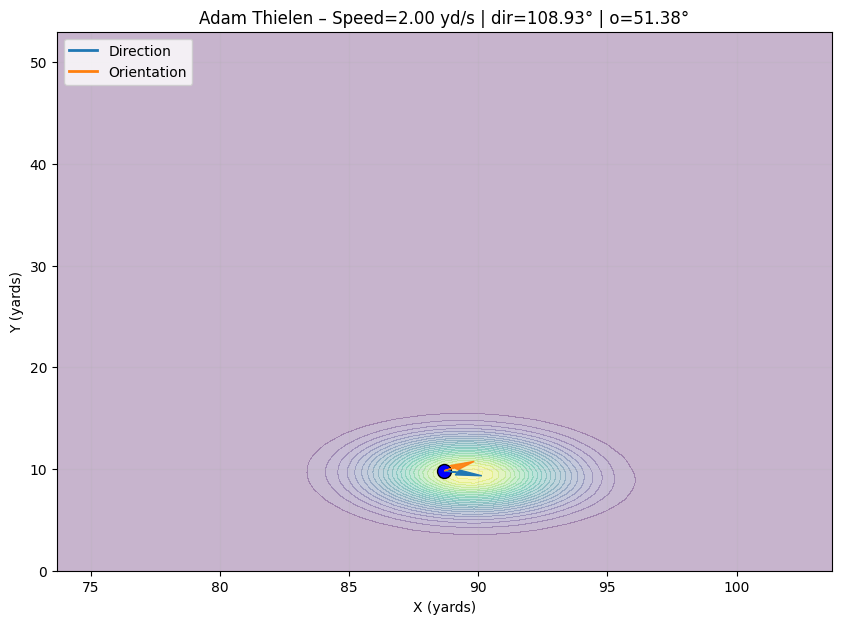

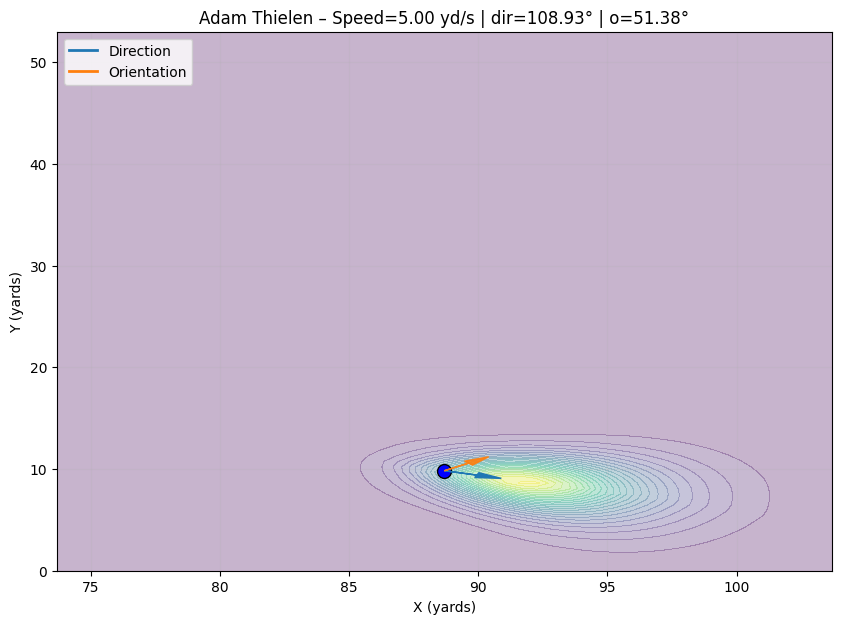

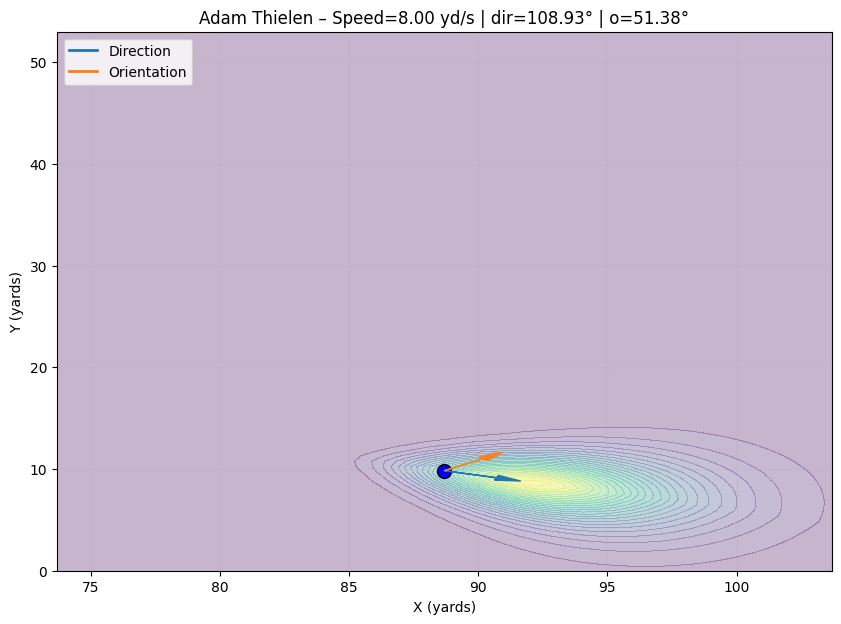

In [100]:
diagnostic_plot(
    df,
    frame_id=150,
    player_ids=one_player,
    speeds=(2, 5, 8),
    orientation_bias_deg=90,
    sigma_gaussian=5,
    gaussian_scale_factor=0.8,
    alpha_gamma=9,
    max_forward_distance=25,
    forward_decay_factor=2.0,
    angle_limit_min=10,
    angle_limit_max=20,
    contour_levels=30,
    cmap='viridis',
    arrow_scale=3.0,          # shorter shaft
    arrow_head_width=0.5,     # smaller head
    arrow_head_length=1.0,    # smaller head
    zoom_x_range=15
)

/tmp/ipython-input-447899552.py:1: DeprecationWarning: diagnostic_plot: `sigma_gaussian` is deprecated and ignored by the current model.
  diagnostic_plot(


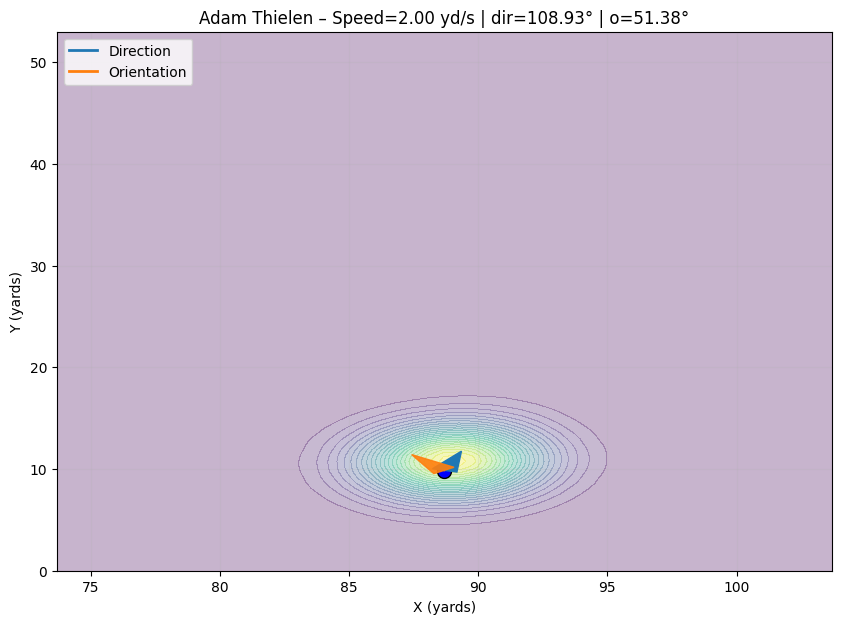

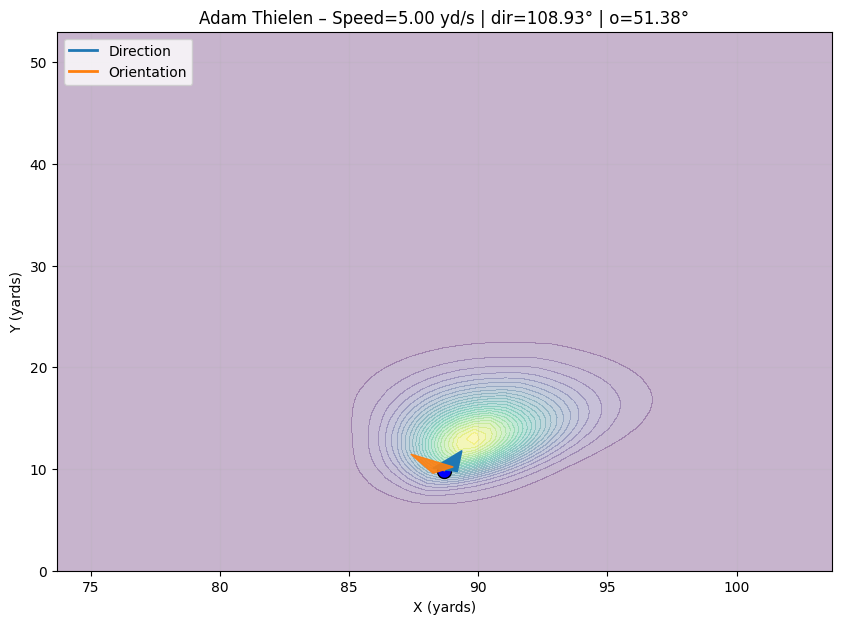

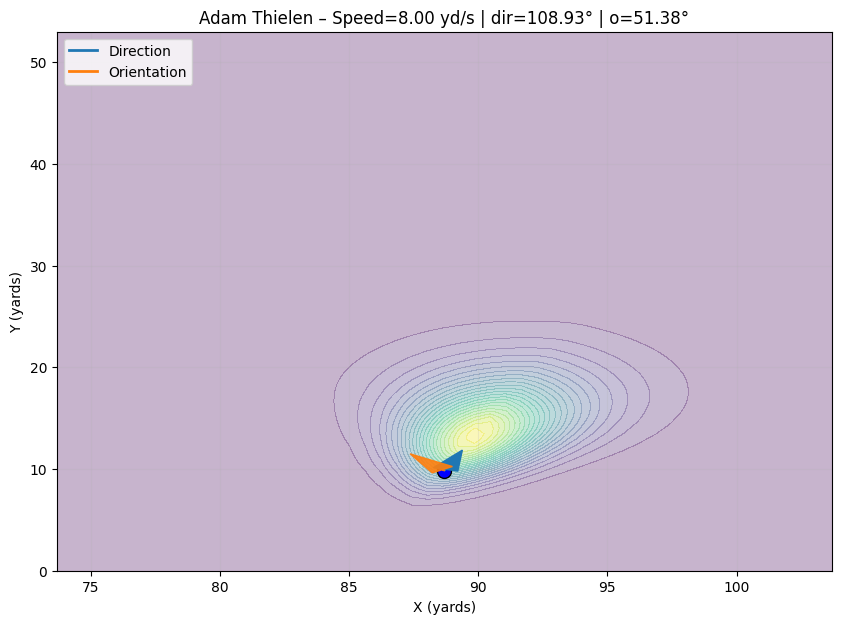

In [92]:
diagnostic_plot(
    df,
    frame_id=150,
    player_ids=one_player,
    speeds=(2, 5, 8),
    orientation_bias_deg=90,
    sigma_gaussian=5,
    gaussian_scale_factor=0.8,
    alpha_gamma=9,
    max_forward_distance=25,
    forward_decay_factor=2.0,
    angle_limit_min=10,
    angle_limit_max=20,
    contour_levels=30,
    cmap='viridis',
    arrow_scale=.2,
    zoom_x_range=15
)

In [42]:
def diagnostic_multiples(
    df: pd.DataFrame,
    frame_id: int,
    player_id: Union[int, Sequence[int]],
    *,
    speed: float = 5.0,                 # Player evaluation speed (yd/s)
    # -------- Baseline knobs (applied to every panel unless overridden) ------
    orientation_bias_deg: float = 90.0, # Global rotation correction; keep 90 for your data
    gaussian_scale_factor: float = 0.7, # Gaussian ellipse size/elongation
    alpha_gamma: float = 11.0,          # Gamma “peakiness” (higher = taller/narrower near mode)
    beta_min: float = 1.0,
    beta_max: float = 20.0,             # Dynamic gamma scale bounds
    gamma_midpoint: float = 15.0,       # Speed where gamma scale changes most
    gamma_scale_factor: float = 0.8,    # Gamma reach multiplier
    max_forward_distance: float = 20.0, # Yards ahead where extra fade begins
    forward_decay_factor: float = 1.0,  # >1 gentler fade past the cap; <1 faster fade
    angle_limit_min: float = 15.0,      # Narrowest cone (at high speeds)
    angle_limit_max: float = 45.0,      # Widest cone (at low speeds)
    angle_decay_factor: float = 2.0,    # How quickly the cone tightens with speed
    w_gaussian_min: float = 0.2,        # Minimum Gaussian weight (at high speed)
    w_gaussian_max: float = 1.0,        # Maximum Gaussian weight (at low speed)
    gaussian_midpoint: float = 4.0,     # Speed where Gaussian weight turns down
    gaussian_steepness: float = 2.0,    # Steepness of the weight transition
    # -------- Plot styling ---------------------------------------------------
    cmap: str = "Reds",
    alpha: float = 0.30,
    contour_levels: int = 18,
    zoom_x_range: float = 12.0,
    ylim: Optional[Tuple[float, float]] = (0.0, 53.0),
    grid_alpha: float = 0.20,
    cols: int = 4,                      # Number of columns in the panel grid
    # -------- Behavior / DF schema ------------------------------------------
    verbose: bool = False,              # Print per-panel parameters to stdout
    x_col: str = "x",
    y_col: str = "y",
    dir_col: str = "dir",               # heading in degrees (0° up +Y, 90° right +X)
    speed_col: str = "s",               # speed in yards/second (not used here; we use `speed`)
    dist_from_ball_col: str = "dist_from_football",
    name_col: str = "displayName",
) -> Tuple[plt.Figure, List[Dict[str, Any]]]:
    """
    Build a compact “cheat sheet” of small contour panels to visualize how each
    hyperparameter affects the **Gaussian–Gamma** influence field for one player.

    For each panel, we start from the given baseline hyperparameters and override
    exactly one “knob”, then plot that density on the same zoomed-in field view.
    Alongside the figure, we return a list of dictionaries containing the exact
    parameters used for each panel—handy for copy/paste into experiments.

    Parameters
    ----------
    df : pandas.DataFrame
        Tracking-like table containing at least:
        ['frameId', x_col, y_col, dir_col, dist_from_ball_col]. If `name_col`
        is present, the 'football' row is ignored.
    frame_id : int
        Frame to visualize.
    player_id : int | Sequence[int]
        A single `nflId` or a list/tuple; the **first** matching row in `frame_id`
        is used to center panels (typical for one focal player).
    speed : float, default 5.0
        Speed in yards/second at which to evaluate the density for all panels.
        (Panels vary model hyperparameters, not the speed.)
    orientation_bias_deg, gaussian_scale_factor, alpha_gamma, beta_min, beta_max,
    gamma_midpoint, gamma_scale_factor, max_forward_distance, forward_decay_factor,
    angle_limit_min, angle_limit_max, angle_decay_factor, w_gaussian_min,
    w_gaussian_max, gaussian_midpoint, gaussian_steepness
        Baseline model hyperparameters; each panel overrides **one** of these to
        illustrate its qualitative effect.
    cmap, alpha, contour_levels
        Matplotlib visuals for filled contours.
    zoom_x_range : float
        Horizontal window width (± yards) around the player's X position.
    ylim : (float, float) | None
        Optional Y-axis bounds. Pass `None` for automatic limits.
    grid_alpha : float
        Grid line transparency.
    cols : int
        Number of panel columns (rows are computed).
    verbose : bool
        If True, print the parameter dict for each panel.
    x_col, y_col, dir_col, speed_col, dist_from_ball_col, name_col : str
        Column names for your DataFrame schema.

    Returns
    -------
    (fig, panel_params) : (matplotlib.figure.Figure, list[dict])
        - `fig` is the assembled cheat-sheet figure.
        - `panel_params` is a list of records of the form
          `{"title": <panel title>, "params": {<flat dict of model settings>}}`.

    Notes
    -----
    - Units: distances in **yards**, speeds in **yards/second**.
    - This function evaluates a single player context (position/heading) for visual
      comparability across panels; if you want to vary speed instead of knobs,
      prefer your `diagnostic_plot` helper.
    """

    # ---- Validate availability of the model --------------------------------
    try:
        PlayerInfluenceModel  # type: ignore[name-defined]
    except NameError as e:
        raise NameError(
            "PlayerInfluenceModelTunable must be defined/imported before calling diagnostic_cheatsheet_tunable()."
        ) from e

    # ---- Select the focal player row ---------------------------------------
    player_ids = np.atleast_1d(player_id)
    frame_rows = df[(df["frameId"] == frame_id) & (df.get(name_col, "") != "football")]
    if frame_rows.empty:
        raise ValueError(f"No player rows found for frame_id={frame_id}.")

    sel = frame_rows[frame_rows["nflId"].isin(player_ids)]
    if sel.empty:
        # fallback: take the first row in frame (helps avoid KeyErrors in demos)
        sel = frame_rows

    row = sel.iloc[0]
    pos = (float(row[x_col]), float(row[y_col]))
    dir_deg = float(row[dir_col])
    dist = float(row[dist_from_ball_col])

    # ---- Helper to build a model with overrides ----------------------------
    def _build_model(**override: Any) -> PlayerInfluenceModel:
        model = PlayerInfluenceModel(
            orientation_bias_deg=orientation_bias_deg,
            gaussian_scale_factor=gaussian_scale_factor,
            alpha_gamma=alpha_gamma,
            beta_min=beta_min, beta_max=beta_max,
            gamma_midpoint=gamma_midpoint, gamma_scale_factor=gamma_scale_factor,
            max_forward_distance=max_forward_distance, forward_decay_factor=forward_decay_factor,
            angle_limit_min=angle_limit_min, angle_limit_max=angle_limit_max, angle_decay_factor=angle_decay_factor,
            w_gaussian_min=w_gaussian_min, w_gaussian_max=w_gaussian_max,
            gaussian_midpoint=gaussian_midpoint, gaussian_steepness=gaussian_steepness,
        )
        # Apply per-panel overrides
        for k, v in override.items():
            if not hasattr(model, k):
                raise AttributeError(f"Unknown model parameter '{k}'")
            setattr(model, k, v)
        return model

    # ---- Panels: list[(title, overrides)] ----------------------------------
    # You can tweak/add/remove to emphasize the knobs you care about most.
    panels: List[Tuple[str, Dict[str, Any]]] = [
        ("Gaussian scale ↓", {"gaussian_scale_factor": max(0.2, gaussian_scale_factor * 0.6)}),
        ("Gaussian scale ↑", {"gaussian_scale_factor": gaussian_scale_factor * 1.4}),

        ("Gamma α ↓ (flatter)", {"alpha_gamma": max(2.0, alpha_gamma * 0.7)}),
        ("Gamma α ↑ (peakier)", {"alpha_gamma": alpha_gamma * 1.3}),

        ("Gamma reach ↓", {"max_forward_distance": max(6.0, max_forward_distance * 0.6)}),
        ("Gamma reach ↑", {"max_forward_distance": max_forward_distance * 1.4}),

        ("Gamma fade fast", {"forward_decay_factor": 0.6}),
        ("Gamma fade slow", {"forward_decay_factor": 2.0}),

        ("Cone narrow", {
            "angle_limit_min": min(max(angle_limit_min, 0.0) + 12.0, max(angle_limit_max - 5.0, angle_limit_min + 12.0)),
            "angle_limit_max": max(min(angle_limit_max, 85.0) - 12.0, angle_limit_min + 5.0),
        }),
        ("Cone wide", {
            "angle_limit_min": max(0.0, angle_limit_min - 12.0),
            "angle_limit_max": min(85.0, angle_limit_max + 12.0),
        }),

        ("More Gaussian", {"w_gaussian_min": min(0.8, w_gaussian_min + 0.2)}),
        ("More Gamma",    {"w_gaussian_min": max(0.0, w_gaussian_min - 0.2)}),
    ]

    # ---- Layout figure ------------------------------------------------------
    n = len(panels)
    cols = max(1, int(cols))
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4.0 * cols, 3.6 * rows))
    axes_arr = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])

    panel_params: List[Dict[str, Any]] = []

    # ---- Render each panel --------------------------------------------------
    for ax, (title, overrides) in zip(axes_arr, panels):
        model = _build_model(**overrides)

        # Keep a reproducible record of the exact parameters used
        params = {
            "orientation_bias_deg": model.orientation_bias_deg,
            "gaussian_scale_factor": model.gaussian_scale_factor,
            "alpha_gamma": model.alpha_gamma,
            "beta_min": model.beta_min,
            "beta_max": model.beta_max,
            "gamma_midpoint": model.gamma_midpoint,
            "gamma_scale_factor": model.gamma_scale_factor,
            "max_forward_distance": model.max_forward_distance,
            "forward_decay_factor": model.forward_decay_factor,
            "angle_limit_min": model.angle_limit_min,
            "angle_limit_max": model.angle_limit_max,
            "angle_decay_factor": model.angle_decay_factor,
            "w_gaussian_min": model.w_gaussian_min,
            "w_gaussian_max": model.w_gaussian_max,
            "gaussian_midpoint": model.gaussian_midpoint,
            "gaussian_steepness": model.gaussian_steepness,
            "speed": speed,
        }
        panel_params.append({"title": title, "params": params})
        if verbose:
            print(f"[{title}] {params}")

        # Compute density for this panel / same player pose
        pos_off = model.compute_offset(pos, dir_deg, speed)
        Z = model.base_distribution(
            pos_xy=pos,
            pos_off_xy=pos_off,
            direction_deg=dir_deg,
            speed=speed,
            dist_from_ball=dist,
            # alpha_gamma is already set on the model; passing here keeps the title honest
            alpha_gamma=model.alpha_gamma,
        )

        # Draw
        X, Y = model.grid.X, model.grid.Y
        ax.contourf(X, Y, Z, levels=contour_levels, cmap=cmap, alpha=alpha)
        ax.scatter(pos[0], pos[1], c="blue", edgecolor="black", s=45, zorder=5)

        theta = model._theta(dir_deg)
        L = (speed / 11.3) * 5.0  # arrow length normalized by ~top speed
        ax.arrow(pos[0], pos[1], L * np.cos(theta), L * np.sin(theta),
                 head_width=0.8, head_length=1.6, fc="black", ec="black", zorder=6)

        ax.set_title(title, fontsize=10)
        ax.set_xlim(pos[0] - zoom_x_range, pos[0] + zoom_x_range)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid(alpha=grid_alpha)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any leftover empty axes (when panels < rows*cols)
    for i in range(len(panels), len(axes_arr)):
        axes_arr[i].axis("off")

    fig.suptitle(
        f"Influence Cheat Sheet • frame {frame_id} • player {player_id} • speed={speed:.2f} yd/s",
        fontsize=14
    )
    fig.tight_layout(rect=[0, 0.02, 1, 0.96])

    return fig, panel_params


Best params: {'orientation_bias_deg': 90.0, 'gaussian_scale_factor': 0.7, 'alpha_gamma': 11.0, 'beta_min': 1.0, 'beta_max': 20.0, 'gamma_midpoint': 15.0, 'gamma_scale_factor': 0.8, 'max_forward_distance': 20.0, 'forward_decay_factor': 2.0, 'angle_limit_min': 15.0, 'angle_limit_max': 45.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.2, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 4.0, 'gaussian_steepness': 2.0, 'speed': 5}


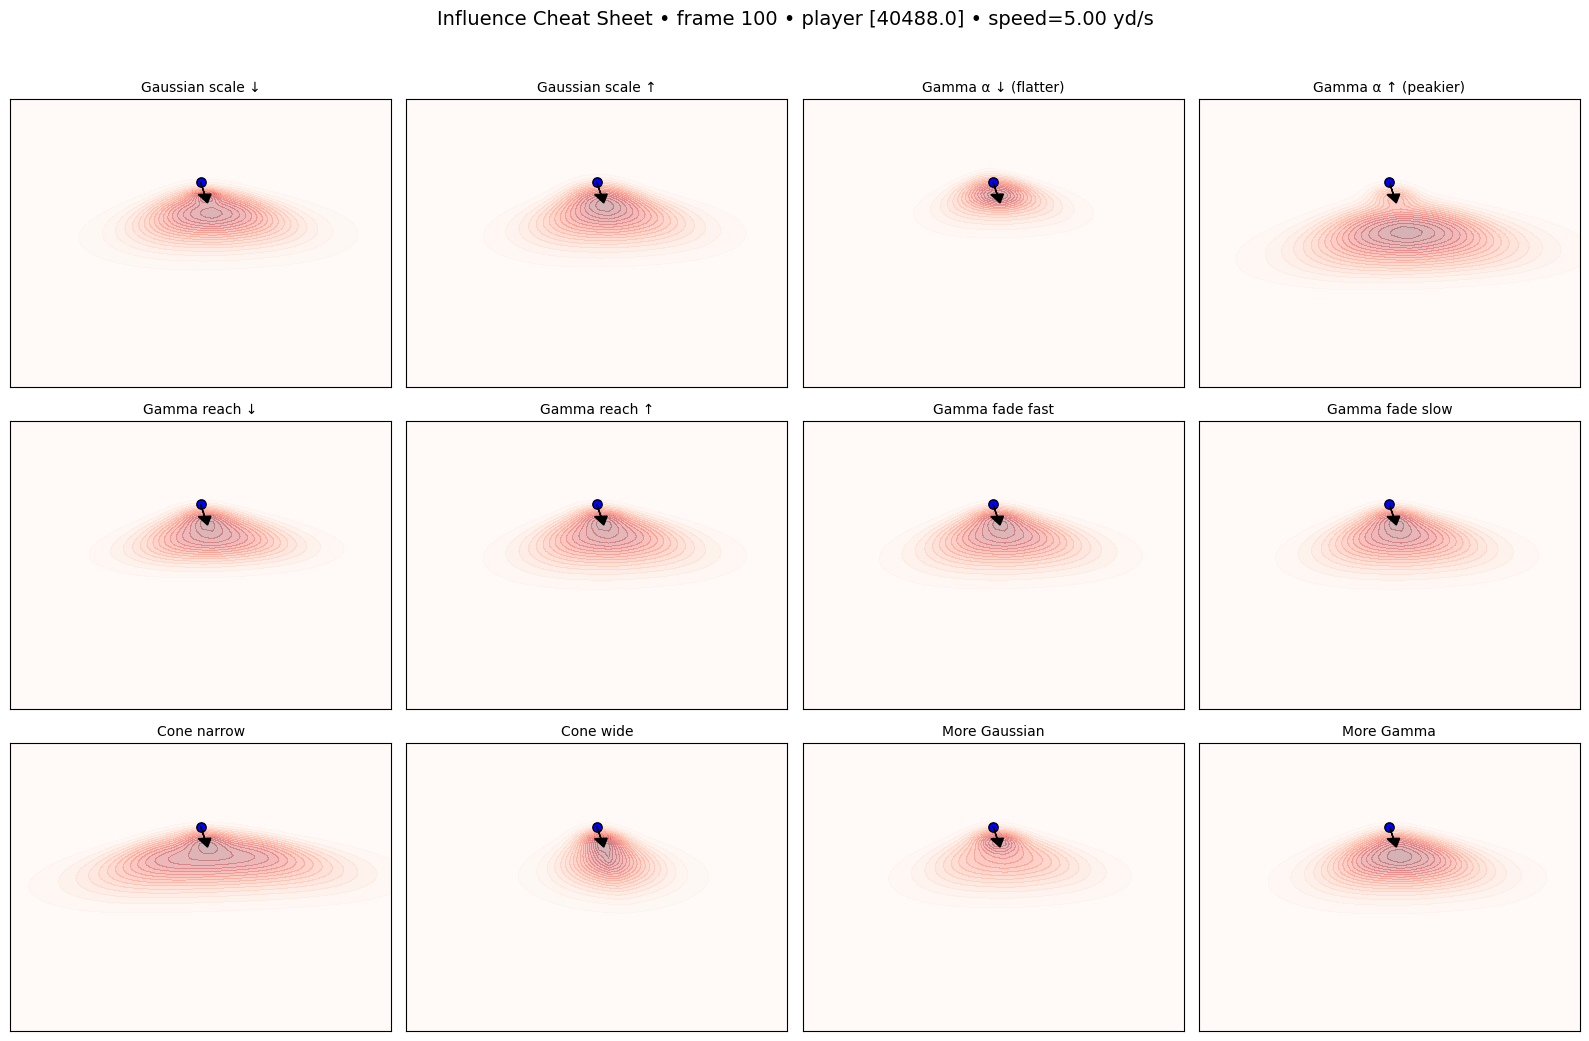

In [43]:
fig, params = diagnostic_multiples(df, frame_id=100, player_id=one_player, speed=5)

# Print the “winner” panel’s settings cleanly
best = next(p for p in params if p["title"] == "Gamma fade slow")  # for example
print("Best params:", best["params"])


In [55]:
def compute_player_densities_dataframe(
    df,
    min_frame,
    max_frame,
    *,
    model_kwargs=None,          # e.g. {"orientation_bias_deg": -90.0, ...}
    sigma_gaussian=5,
    alpha_gamma=11,
    exclude_football=True
):
    """
    Compute Gaussian–Gamma densities for all players across [min_frame, max_frame]
    using PlayerInfluenceModelTunable. Stores the orientation bias used so plotting
    can automatically match it later.
    Returns:
      - all_player_df: one row per (frameId, nflId) with the 2D 'density' grid
      - (X, Y): the model's grid
    """
    if min_frame > max_frame:
        raise ValueError("min_frame must be less than or equal to max_frame.")

    model = PlayerInfluenceModelTunable(**(model_kwargs or {}))
    X, Y = model.grid

    df_range = df[(df["frameId"] >= min_frame) & (df["frameId"] <= max_frame)].copy()
    if exclude_football and "displayName" in df_range.columns:
        df_range = df_range[df_range["displayName"] != "football"]

    rows_out = []
    for frame_id in sorted(df_range["frameId"].unique()):
        frame_df = df_range[df_range["frameId"] == frame_id]
        if frame_df.empty:
            continue

        for _, r in frame_df.iterrows():
            try:
                pos = (r["x"], r["y"])
                dir_deg = r["dir"]
                spd = r["s"]
                dball = r.get("dist_from_football", 0.0)

                pos_off = model.compute_offset(pos, dir_deg, spd)
                Z = model.base_distribution(
                    pos, pos_off, dir_deg, spd,
                    sigma_gaussian=sigma_gaussian,
                    alpha_gamma=alpha_gamma,
                    dist_from_ball=dball
                )

                rows_out.append({
                    "frameId": frame_id,
                    "nflId": r["nflId"],
                    "displayName": r.get("displayName", None),
                    "jerseyNumber": r.get("jerseyNumber", None),
                    "x": pos[0],
                    "y": pos[1],
                    "speed": spd,
                    "direction": dir_deg,                   # raw tracking dir
                    "is_off": r.get("is_off", None),
                    "dist_from_football": dball,
                    "orientation_bias_deg": model.orientation_bias_deg,  # <-- store the bias used
                    "density": Z
                })
            except Exception as e:
                print(f"Error processing nflId={r.get('nflId')} in frame {frame_id}: {e}")

    all_player_df = pd.DataFrame(rows_out)
    return all_player_df, (X, Y)



In [58]:
# 1) Compute densities (bias is saved into the dataframe)
all_player_df, grid = compute_player_densities_dataframe(
    df,
    min_frame=100,
    max_frame=110,
    model_kwargs={
        "orientation_bias_deg": 90.0,     # ← pick your bias ONCE here (e.g., -90.0 for “downfield”)
        "gaussian_scale_factor": 0.7,
        "alpha_gamma": 7,
        "max_forward_distance": 20.0,
        "forward_decay_factor": 1.2,
        "angle_limit_min": 3,
        "angle_limit_max": 57,
        "angle_decay_factor": 2.0,
        "w_gaussian_min": 0.2,
        "w_gaussian_max": 1.0,
        "gaussian_midpoint": 4.0,
        "gaussian_steepness": 2.0,
    },
    sigma_gaussian=5,
    alpha_gamma=11,
)


/tmp/ipython-input-932318980.py:131: RuntimeWarning: divide by zero encountered in divide
  H[mask] *= np.exp(-((d_proj[mask] - self.max_forward_distance) ** 2) / (2 * (speed * fade) ** 2))


In [59]:
def plot_player_densities_from_dataframe(
    player_df,
    grid,
    frame_id,
    *,
    orientation_bias_deg=90.0,     # fallback if a row doesn't have a stored bias
    contour_levels=20,
    contour_alpha=0.30,
    off_cmap="Reds",
    on_cmap="Blues",
    arrow_scale=2.0,
    arrow_head_width=0.375,
    arrow_head_length=0.75,
    xlim=None,
    ylim=None,
    grid_alpha=0.10,
    title="Individual Player Influence",
    show=True
):
    """
    Plot precomputed densities. Arrows are aligned to each row's stored
    orientation bias (used during density computation). If missing, uses
    `orientation_bias_deg` provided here as a fallback.
    """

    def _norm(a): return (a + 360) % 360
    def _corrected(deg): return _norm(90 - deg)
    def _double_corrected(deg): return _corrected(_corrected(deg))
    def _theta(dir_deg, bias_deg):  # radians
        return np.radians(_norm(_double_corrected(dir_deg) + bias_deg))

    X, Y = grid
    _MAX_FIELD_X, _MAX_FIELD_Y = 120, 53.3

    f = player_df[player_df["frameId"] == frame_id].copy()
    if f.empty:
        print(f"Warning: no players found for frameId={frame_id}")
        return

    aspect = _MAX_FIELD_Y / _MAX_FIELD_X
    fig, ax = plt.subplots(figsize=(20, 20 * aspect))

    for x in range(10, 120, 10):
        ax.axvline(x, color="k", linestyle="-", alpha=0.05)

    for _, row in f.iterrows():
        if str(row.get("displayName", "")).lower() == "football":
            continue

        # choose colors by offense/defense
        is_off = row.get("is_off", None)
        player_color = "blue" if is_off == 1 else "red"
        density_cmap = on_cmap if is_off == 1 else off_cmap

        # use per-row stored bias if present
        row_bias = row.get("orientation_bias_deg", orientation_bias_deg)

        Z = row["density"]
        Z_masked = np.where(Z > 0.01, Z, np.nan)
        ax.contourf(X, Y, Z_masked, cmap=density_cmap, levels=contour_levels, alpha=contour_alpha)

        x0, y0 = row["x"], row["y"]
        ax.scatter(x0, y0, color=player_color, s=200, edgecolor="black", zorder=5)

        jn = row.get("jerseyNumber", None)
        if jn is not None and not (isinstance(jn, float) and np.isnan(jn)):
            ax.text(x0, y0, f"{int(jn)}", fontsize=8, ha="center", color="white", zorder=6)

        name = row.get("displayName", None)
        if name:
            ax.text(x0, y0 - 1.5, str(name), fontsize=8, ha="center", color="black", zorder=6)

        dir_deg = row.get("direction", row.get("orientation", None))
        if dir_deg is not None:
            th = _theta(dir_deg, row_bias)
            spd = row.get("speed", 0.0)
            L = arrow_scale * (1.0 + min(max(spd, 0.0), 11.3) / 11.3)  # modest speed scaling
            ax.arrow(
                x0, y0,
                L * np.cos(th), L * np.sin(th),
                head_width=arrow_head_width, head_length=arrow_head_length,
                fc="black", ec="black", zorder=4
            )

    ax.set_title(f"{title} — Frame {frame_id}")
    ax.set_xlabel("X (yards)")
    ax.set_ylabel("Y (yards)")
    ax.grid(alpha=grid_alpha)

    ax.set_xlim(*xlim) if xlim else ax.set_xlim(0, _MAX_FIELD_X)
    ax.set_ylim(*ylim) if ylim else ax.set_ylim(0, _MAX_FIELD_Y)

    if show:
        plt.show()

    return fig, ax


In [60]:
# 1. Compute densities for a range of frames
all_player_df, grid = compute_player_densities_dataframe(df, min_frame=100, max_frame=132)

# 2. Pick a frame to visualize
frame_to_plot = 120

/tmp/ipython-input-932318980.py:131: RuntimeWarning: divide by zero encountered in divide
  H[mask] *= np.exp(-((d_proj[mask] - self.max_forward_distance) ** 2) / (2 * (speed * fade) ** 2))


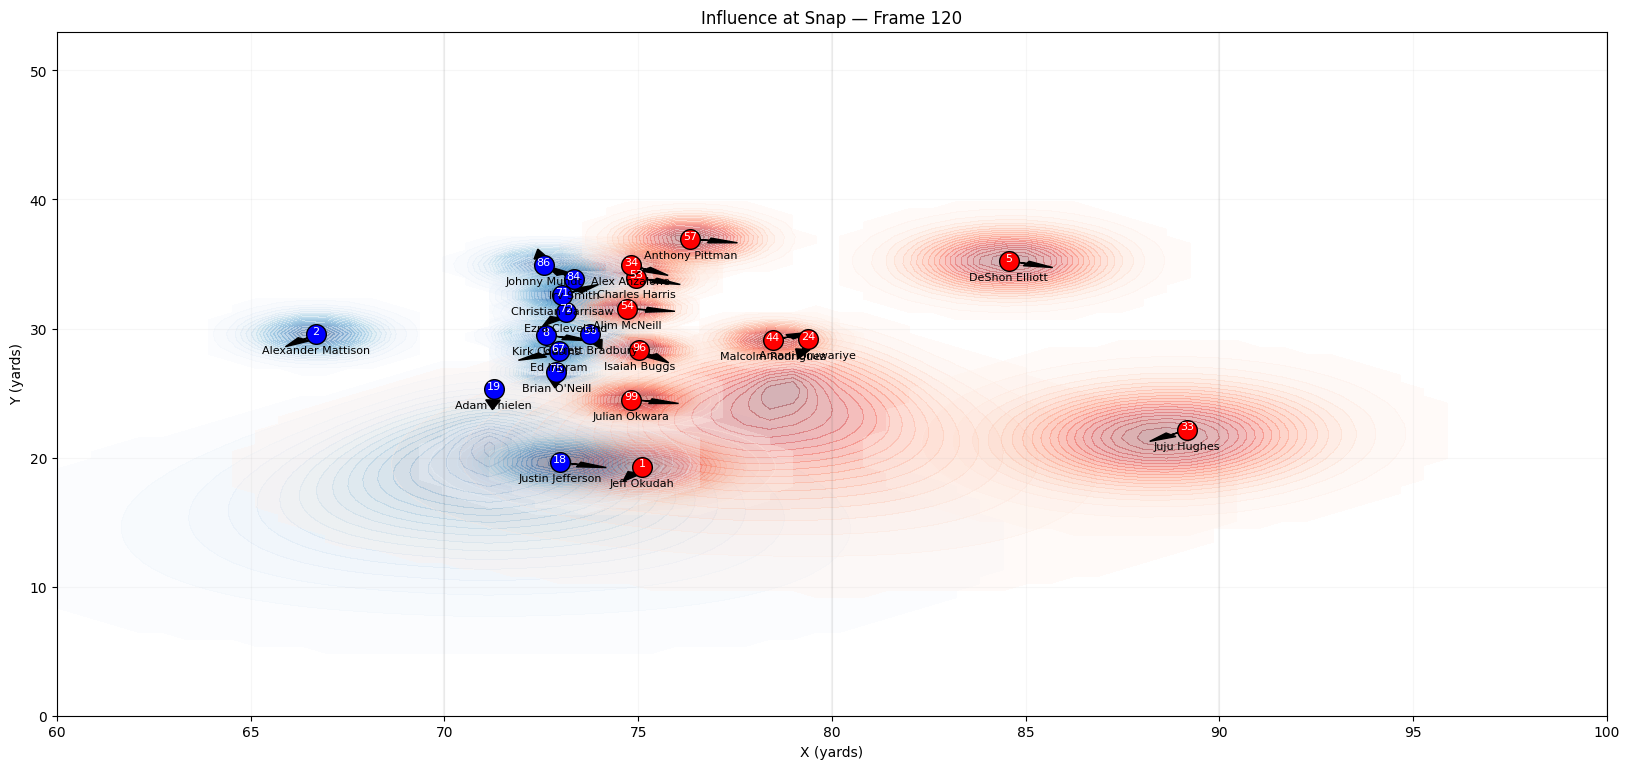

(<Figure size 2000x888.333 with 1 Axes>,
 <Axes: title={'center': 'Influence at Snap — Frame 120'}, xlabel='X (yards)', ylabel='Y (yards)'>)

In [61]:

# 3) Plot (no need to pass orientation_bias_deg—plotter uses per-row stored bias)
plot_player_densities_from_dataframe(
    all_player_df,
    grid,
    frame_id=frame_to_plot,
    contour_levels=20,
    contour_alpha=0.3,
    off_cmap="Reds",
    on_cmap="Blues",
    arrow_scale=0.5,
    xlim=(60, 100),
    ylim=(0, 53),
    title="Influence at Snap",
)

In [ ]:

class AnimatePlayWithDensity:
    def __init__(
        self,
        play_df,
        precomputed_df,
        grid,
        plot_size_len=16,
        *,
        # contours
        show_contours=True,
        contour_levels=20,
        contour_alpha=0.30,
        off_cmap="Reds",
        on_cmap="Blues",
        # arrows
        arrow_scale=2.0,             # base arrow length in yards, will be modestly scaled by speed
        arrow_head_width=0.375,
        arrow_head_length=0.75,
        # orientation fallback (used only if theta_rad is not stored in precomputed_df)
        orientation_bias_deg=90.0,    # << your class now uses +90 (not -90)
        # view
        xlim=None, ylim=None, grid_alpha=0.10,
        title="Play Animation with Influence"
    ) -> None:
        """
        Animate a play with precomputed densities (from PlayerInfluenceModelTunable).

        - `precomputed_df` should be the output of `compute_player_densities_dataframe`
           that includes columns: frameId, nflId, x, y, speed, is_off, density,
           and ideally theta_rad (exact heading used by the model) + orientation_bias_deg.
        - If theta_rad is present, arrows use it directly; otherwise they fall back to
          the same orientation convention your class uses (double-correct + bias).
        """
        # constants
        self._MAX_FIELD_Y = 53.3
        self._MAX_FIELD_X = 120
        self._MAX_FIELD_PLAYERS = 22  # max players to pre-allocate text/arrow artists

        # data
        self._frame_data = play_df
        self._precomputed_df = precomputed_df
        self._X, self._Y = grid
        self._frames = sorted(play_df.frameId.unique())

        # style / options
        self.show_contours = show_contours
        self.contour_levels = contour_levels
        self.contour_alpha = contour_alpha
        self.off_cmap = off_cmap
        self.on_cmap = on_cmap

        self.arrow_scale = arrow_scale
        self.arrow_head_width = arrow_head_width
        self.arrow_head_length = arrow_head_length

        self.orientation_bias_deg = orientation_bias_deg  # fallback only
        self.xlim = xlim
        self.ylim = ylim
        self.grid_alpha = grid_alpha
        self._title = title

        # stream
        self._stream = self.data_stream()

        # fig/axes
        aspect = self._MAX_FIELD_Y / self._MAX_FIELD_X
        self._fig = plt.figure(figsize=(plot_size_len, plot_size_len * aspect))
        self._ax_field = plt.gca()

        # storage for artists
        self._scat_jersey_list = []
        self._scat_number_list = []
        self._scat_name_list = []
        self._a_dir_list = []
        self._a_or_list = []
        self._contours = []

        # start animation
        self.ani = animation.FuncAnimation(
            self._fig, self.update, frames=len(self._frames),
            init_func=self.setup_plot, blit=False
        )
        plt.close()

    # ---------- orientation helpers (fallback only if theta_rad missing) ----------
    @staticmethod
    def _norm(a): return (a + 360.0) % 360.0
    def _corrected(self, deg): return self._norm(90.0 - deg)
    def _double_corrected(self, deg): return self._corrected(self._corrected(deg))
    def _theta_fallback(self, dir_deg):
        # radians: (double-corrected) + global bias
        return np.radians(self._norm(self._double_corrected(dir_deg) + self.orientation_bias_deg))

    # ---------- plumbing ----------
    @staticmethod
    def set_axis_plots(ax, max_x, max_y) -> None:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_xlim([0, max_x])
        ax.set_ylim([0, max_y])

    def data_stream(self):
        for frame in self._frames:
            yield self._frame_data[self._frame_data.frameId == frame]

    def setup_plot(self):
        # Field setup
        self.set_axis_plots(self._ax_field, self._MAX_FIELD_X, self._MAX_FIELD_Y)
        for idx in range(10, 120, 10):
            self._ax_field.axvline(idx, color='k', linestyle='-', alpha=0.05)

        # Initial scatters
        self._scat_ball = self._ax_field.scatter([], [], s=100, color='black', label="Football")
        self._scat_offense = self._ax_field.scatter([], [], s=500, color='blue', edgecolors='k', label="Offense")
        self._scat_defense = self._ax_field.scatter([], [], s=500, color='red', edgecolors='k', label="Defense")

        # Pre-allocate text + arrows (so we can update in-place)
        for _ in range(self._MAX_FIELD_PLAYERS):
            self._scat_jersey_list.append(self._ax_field.text(0, 0, '', ha='center', va='center', c='white'))
            self._scat_number_list.append(self._ax_field.text(0, 0, '', ha='center', va='center', c='black'))
            self._scat_name_list.append(self._ax_field.text(0, 0, '', ha='center', va='center', c='black'))
            self._a_dir_list.append(self._ax_field.add_patch(Arrow(0, 0, 0, 0, color='k')))
            self._a_or_list.append(self._ax_field.add_patch(Arrow(0, 0, 0, 0, color='grey', width=2)))

        # Title & view
        self._ax_field.set_title(self._title)
        if self.xlim: self._ax_field.set_xlim(*self.xlim)
        if self.ylim: self._ax_field.set_ylim(*self.ylim)
        self._ax_field.grid(alpha=self.grid_alpha)

        return (self._scat_ball, self._scat_offense, self._scat_defense, *self._scat_jersey_list)

    def clear_contours_safe(self, contours_list):
        """
        Safely clear matplotlib contours across different versions
        """
        for contour in contours_list:
            try:
                # Try the most common approaches
                if hasattr(contour, 'collections'):
                    # Newer matplotlib
                    for collection in contour.collections:
                        collection.remove()
                elif hasattr(contour, 'remove'):
                    # Direct removal
                    contour.remove()
                else:
                    # Try iterating (some contour objects are iterable)
                    for artist in contour:
                        if hasattr(artist, 'remove'):
                            artist.remove()
            except (TypeError, AttributeError, ValueError):
                # Skip problematic contours
                continue

        contours_list.clear()

    def update(self, _frame_index):
        # grab next frame of positional data
        pos_df = next(self._stream)
        frame_id = int(pos_df.frameId.iloc[0])

        # split
        offense_df = pos_df[pos_df.is_off == 1]
        defense_df = pos_df[pos_df.is_off == 0]
        ball_df    = pos_df[pos_df.team == 'football'] if 'team' in pos_df.columns \
                     else pos_df[pos_df.displayName.str.lower() == 'football']

        # update scatters
        if not offense_df.empty:
            self._scat_offense.set_offsets(np.vstack([offense_df.x, offense_df.y]).T)
        if not defense_df.empty:
            self._scat_defense.set_offsets(np.vstack([defense_df.x, defense_df.y]).T)
        if not ball_df.empty:
            self._scat_ball.set_offsets(np.vstack([ball_df.x, ball_df.y]).T)

        self._ax_field.set_title(f"{self._title} — Frame {frame_id}")

        # clear old contours - FIXED VERSION
        self.clear_contours_safe(self._contours)

        # plot densities for this frame
        if self.show_contours:
            frame_density_df = self._precomputed_df[self._precomputed_df.frameId == frame_id]
            for _, prow in frame_density_df.iterrows():
                Z = prow['density']
                if Z is None:
                    continue
                cmap = self.on_cmap if prow.get('is_off', 0) == 1 else self.off_cmap
                Z_masked = np.where(Z > 0.01, Z, np.nan)
                cont = self._ax_field.contourf(self._X, self._Y, Z_masked,
                                               cmap=cmap, levels=self.contour_levels, alpha=self.contour_alpha)
                self._contours.append(cont)

        # update per-player labels + arrows
        labeled = pos_df[pos_df.jerseyNumber.notnull()].reset_index(drop=True)
        for idx in range(min(len(labeled), self._MAX_FIELD_PLAYERS)):
            row = labeled.iloc[idx]
            x0, y0 = row.x, row.y

            # jersey/number/name
            self._scat_jersey_list[idx].set_position((x0, y0))
            self._scat_jersey_list[idx].set_text(row.position if 'position' in row else '')
            self._scat_number_list[idx].set_position((x0, y0 + 1.5))
            try:
                jn = int(row.jerseyNumber)
                self._scat_number_list[idx].set_text(jn)
            except Exception:
                self._scat_number_list[idx].set_text('')
            self._scat_name_list[idx].set_position((x0, y0 - 1.5))
            name = row.displayName.split()[-1] if isinstance(row.displayName, str) else ''
            self._scat_name_list[idx].set_text(name)

            # heading for arrows
            # Prefer theta_rad stored in precomputed_df for this player+frame
            theta_rad = None
            match = self._precomputed_df[
                (self._precomputed_df.frameId == frame_id) & (self._precomputed_df.nflId == row.nflId)
            ]
            if not match.empty:
                theta_rad = match.iloc[0].get('theta_rad', None)

            if theta_rad is None:
                # fallback to same convention the model uses: double-correct + +90 bias
                theta_rad = self._theta_fallback(row.dir)

            # direction arrow length (modest speed scaling)
            spd = float(row.s) if 's' in row else 0.0
            L = self.arrow_scale * (1.0 + min(max(spd, 0.0), 11.3) / 11.3)

            # "direction" (black) arrow
            self._a_dir_list[idx].remove()
            self._a_dir_list[idx] = self._ax_field.add_patch(
                Arrow(x0, y0, L*np.cos(theta_rad), L*np.sin(theta_rad),
                      color='k', width=0.0, alpha=1.0)
            )

            # "orientation" (grey) arrow — optional (uses row.o if present)
            orient_theta = None
            if 'o' in row and not np.isnan(row.o):
                # orientation often differs from 'dir'; draw shorter, in grey
                orient_theta = self._theta_fallback(row.o)
            self._a_or_list[idx].remove()
            if orient_theta is not None:
                self._a_or_list[idx] = self._ax_field.add_patch(
                    Arrow(x0, y0, (L*0.6)*np.cos(orient_theta), (L*0.6)*np.sin(orient_theta),
                          color='grey', width=2, alpha=0.9)
                )
            else:
                self._a_or_list[idx] = self._ax_field.add_patch(Arrow(0,0,0,0,color='grey',width=0))

        return (self._scat_ball, self._scat_offense, self._scat_defense, *self._scat_jersey_list)

In [ ]:
# precompute (stores theta_rad + orientation_bias_deg per row)
all_player_df, grid = compute_player_densities_dataframe(
    df,
    min_frame=1, max_frame=200,
    model_kwargs={"orientation_bias_deg": 90.0},  # << your fixed class bias
    sigma_gaussian=5, alpha_gamma=11
)

# subset your tracking data to the same play/frames
play_df = df[(df["frameId"] >= 1) & (df["frameId"] <= 200)].copy()

# animate
anim = AnimatePlayWithDensity(
    play_df=play_df,
    precomputed_df=all_player_df,
    grid=grid,
    plot_size_len=16,
    show_contours=True,
    contour_levels=20,
    contour_alpha=0.3,
    on_cmap="Blues",
    off_cmap="Reds",
    arrow_scale=1.5,
    orientation_bias_deg=0,  # only used as fallback if theta_rad missing
    xlim=(60, 100), ylim=(10, 40),
    title="Influence Over Time"
)

anim.ani.save("play_with_densities_test.mp4", fps=10)
files.download("play_with_densities_test.mp4")

plt.show()

/tmp/ipython-input-4205020669.py:131: RuntimeWarning: divide by zero encountered in divide
  H[mask] *= np.exp(-((d_proj[mask] - self.max_forward_distance) ** 2) / (2 * (speed * fade) ** 2))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:


def compute_player_densities_with_pitch_control(
    model,
    df,
    frame_id,
    *,
    grid=None,                          # (X, Y) tuple; if None, uses model.grid or builds default
    smooth_sigma=2.0,                   # gaussian smoothing for influence maps
    pitch_k=25.0,                       # sigmoid steepness for pitch control
    neutral_band=(0.45, 0.55),          # mask band for "neutral" areas
    use_cached_density=True,            # use 'density' column if available
    cache_back_to_df=False              # if computed, store density back onto df for reuse
):
    """
    Compute offense/defense influence and pitch control for a single frame using a tunable model.

    Parameters
    ----------
    model : PlayerInfluenceModelTunable-like
        Expected to expose either:
          - a batch method: `compute_densities(frame_df, X, Y) -> np.ndarray[n_players, Y, X]`
        or per-row method:
          - `compute_density(row, X, Y) -> np.ndarray[Y, X]`
        Optionally may expose `model.grid` as a (X, Y) meshgrid.
    df : pandas.DataFrame
        Tracking-like frame data with at least:
          ['frameId','displayName','nflId','jerseyNumber','x','y','speed','direction','is_off']
        If `use_cached_density=True`, can include a 'density' column (array-like per row).
    frame_id : int
        Frame to compute.
    grid : tuple(np.ndarray, np.ndarray) or None
        Meshgrid (X, Y). If None, use `model.grid` if present, otherwise default to 120x53.3.
    smooth_sigma : float
        Sigma passed to `scipy.ndimage.gaussian_filter` for smoothing influence maps.
    pitch_k : float
        Steepness for the sigmoid that maps influence diff -> [0,1] control.
    neutral_band : (float, float)
        Inclusive band to mask out near-50/50 regions.
    use_cached_density : bool
        If True and a 'density' column exists, use it.
    cache_back_to_df : bool
        If True and densities are computed via the model, write them back to a 'density' column.

    Returns
    -------
    player_df : pd.DataFrame
        Per-player influence summaries (includes 'density' and 'sum_density').
    offense_influence_df : pd.DataFrame
        Smoothed offensive influence grid (indexed by y, columns by x).
    defense_influence_df : pd.DataFrame
        Smoothed defensive influence grid (indexed by y, columns by x).
    pitch_control_df : pd.DataFrame
        Pitch control grid (masked in neutral_band).
    """

    # --- grid setup ----------------------------------------------------------
    if grid is not None:
        X, Y = grid
    elif hasattr(model, "grid") and model.grid is not None:
        X, Y = model.grid
    else:
        x_vals = np.linspace(0.0, 120.0, 200)
        y_vals = np.linspace(0.0, 53.3, 100)
        X, Y = np.meshgrid(x_vals, y_vals)

    x_vals = X[0, :]
    y_vals = Y[:, 0]

    # --- helpers -------------------------------------------------------------
    def _sigmoid(z, k):
        return 1.0 / (1.0 + np.exp(-k * z))

    # --- frame slice ---------------------------------------------------------
    frame_df = df[df["frameId"] == frame_id]
    if frame_df.empty:
        raise ValueError(f"No data found for frame {frame_id}.")

    # Exclude ball / invalid rows up front
    frame_df = frame_df.loc[
        (frame_df["displayName"].str.lower() != "football")
        & (~frame_df["is_off"].isna())
    ].copy()

    # --- density acquisition -------------------------------------------------
    # Try batch path first if available and not using cache:
    densities = None
    can_batch = hasattr(model, "compute_densities")

    if use_cached_density and "density" in frame_df.columns and frame_df["density"].notna().all():
        # Use cached densities
        densities = np.stack(frame_df["density"].to_numpy(), axis=0)
    else:
        if can_batch:
            densities = model.compute_densities(frame_df, X, Y)  # expected shape: (n_players, Y, X)
            if cache_back_to_df:
                frame_df.loc[:, "density"] = list(densities)
        else:
            # Row-by-row fallback
            dens_list = []
            for _, row in frame_df.iterrows():
                d = model.compute_density(row, X, Y)  # expected shape: (Y, X)
                dens_list.append(d)
            densities = np.stack(dens_list, axis=0)
            if cache_back_to_df:
                frame_df.loc[:, "density"] = dens_list

    # --- threshold tiny values to remove speckle -----------------------------
    densities = np.where(densities < 1e-3, 0.0, densities)

    # --- split & accumulate offense/defense ---------------------------------
    is_off_mask = frame_df["is_off"].to_numpy().astype(bool)
    inf_offense = densities[is_off_mask].sum(axis=0) if is_off_mask.any() else np.zeros_like(X)
    inf_defense = densities[~is_off_mask].sum(axis=0) if (~is_off_mask).any() else np.zeros_like(X)

    # --- normalize to [0,1] before smoothing (guards against blowups) -------
    def _safe_norm(A):
        mx = A.max()
        return A / mx if mx > 0 else A

    inf_offense = _safe_norm(inf_offense)
    inf_defense = _safe_norm(inf_defense)

    # --- smooth to reduce artifacts -----------------------------------------
    if smooth_sigma and smooth_sigma > 0:
        inf_offense = gaussian_filter(inf_offense, sigma=smooth_sigma)
        inf_defense = gaussian_filter(inf_defense, sigma=smooth_sigma)

    # --- pitch control -------------------------------------------------------
    # convention: higher value -> defense control; invert if you want offense
    pitch_control = _sigmoid(inf_defense - inf_offense, k=pitch_k)

    # mask near-50/50 band
    lo, hi = neutral_band
    mask = (pitch_control >= lo) & (pitch_control <= hi)
    pitch_control_masked = np.where(mask, np.nan, pitch_control)

    # --- per-player summary table -------------------------------------------
    sum_density = densities.reshape(densities.shape[0], -1).sum(axis=1)
    player_df = frame_df.assign(
        frameId=frame_id,
        sum_density=sum_density,
    ).copy()

    # Keep a consistent column order if you like:
    keep_cols = [
        "frameId", "nflId", "displayName", "jerseyNumber",
        "x", "y", "direction", "speed", "is_off", "density", "sum_density"
    ]
    player_df = player_df[[c for c in keep_cols if c in player_df.columns]]

    # --- grid -> DataFrames --------------------------------------------------
    offense_influence_df = pd.DataFrame(inf_offense, index=y_vals, columns=x_vals)
    defense_influence_df = pd.DataFrame(inf_defense, index=y_vals, columns=x_vals)
    pitch_control_df   = pd.DataFrame(pitch_control_masked, index=y_vals, columns=x_vals)

    return player_df, offense_influence_df, defense_influence_df, pitch_control_df


In [63]:
def visualize_pitch_control_with_players(pitch_control_df, player_df, frame_id):
    """
    Visualize the pitch control grid for a single frame with player positions, jersey numbers,
    player names, and directional arrows based on speed and orientation.
    """
    def corrected_orientation(original_orientation):
        """Correct orientation: 0° is North, 90° is East."""
        return (90 - original_orientation) % 360

    plt.figure(figsize=(12, 6))
    plt.title(f"Team Field Control - At Snap")

    # Plot pitch control
    plt.contourf(pitch_control_df.columns, pitch_control_df.index, pitch_control_df,
                 cmap='coolwarm', levels=20, alpha=0.8)
    plt.colorbar(label="Field Control")

    # Plot player positions and details
    for _, row in player_df[player_df['frameId'] == frame_id].iterrows():
        color = 'blue' if row.is_off else 'red'  # Offensive (red) or defensive (blue)
        player_pos = (row.x, row.y)

        # Plot player position
        plt.scatter(player_pos[0], player_pos[1], color=color, edgecolor='black', s=100, zorder=5)

        # Add player jersey number and name
        if pd.notna(row['jerseyNumber']):
            plt.text(player_pos[0], player_pos[1] + 1, f"{int(row['jerseyNumber'])}",
                     fontsize=10, ha='center', color='black', zorder=6)
        if pd.notna(row['displayName']):
            plt.text(player_pos[0], player_pos[1] - 1.5, row['displayName'],
                     fontsize=8, ha='center', color='black', zorder=6)

        # Add directional arrow based on orientation and speed
        if pd.notna(row['direction']) and pd.notna(row['speed']):
            theta = np.radians(corrected_orientation(row['direction']))
            arrow_length = row['speed'] / 11.3 * 5  # Normalize arrow length
            plt.arrow(player_pos[0], player_pos[1],
                      arrow_length * np.cos(theta),
                      arrow_length * np.sin(theta),
                      head_width=.375, head_length=.75, fc='black', ec='black', zorder=2)
    plt.xlim(60,110)
    plt.ylim(5,45)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(alpha=0.5)
    plt.show()


/tmp/ipython-input-932318980.py:131: RuntimeWarning: divide by zero encountered in divide
  H[mask] *= np.exp(-((d_proj[mask] - self.max_forward_distance) ** 2) / (2 * (speed * fade) ** 2))


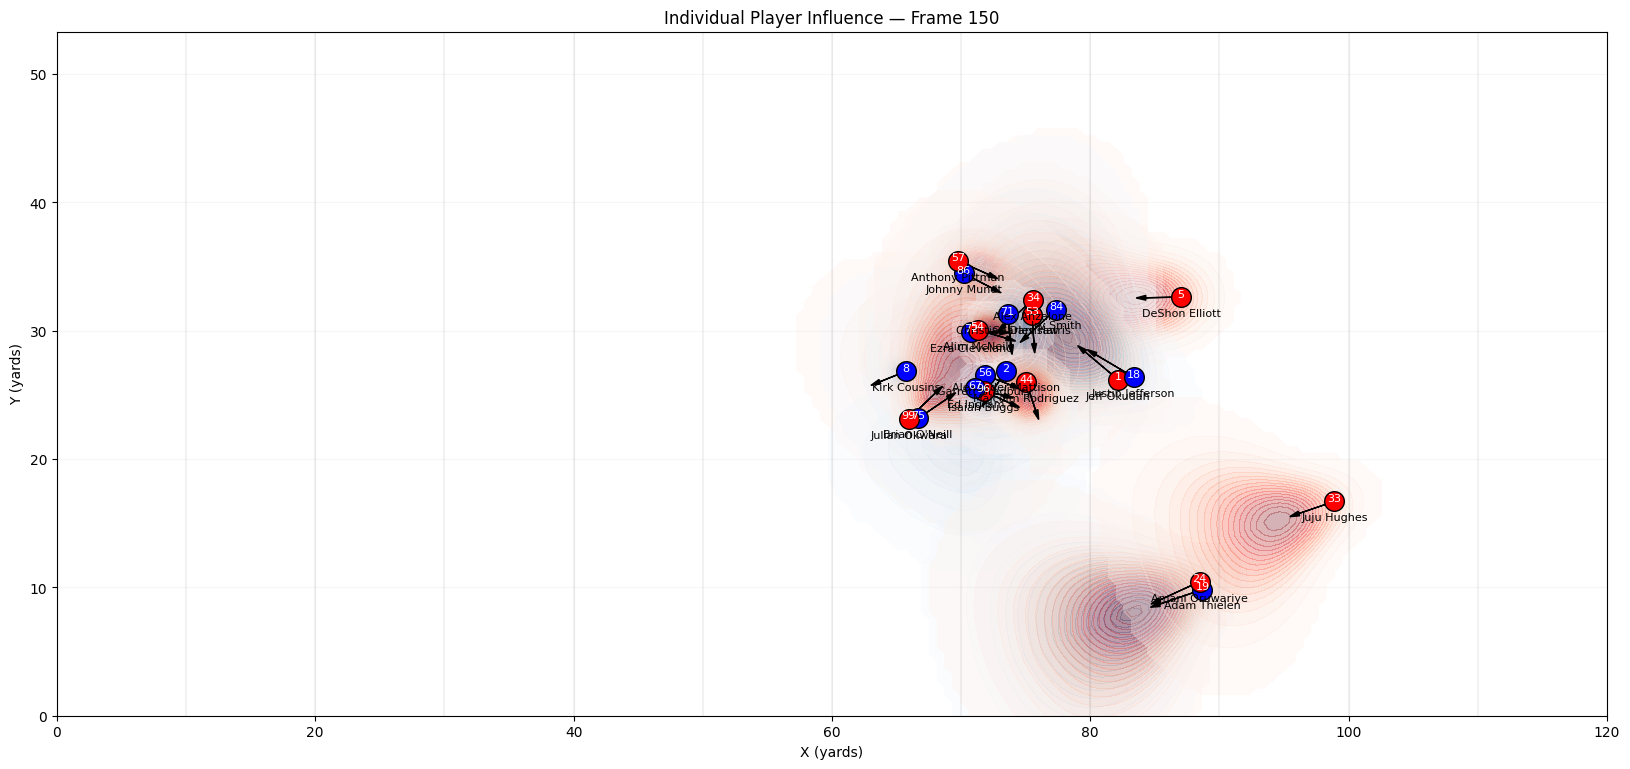

(<Figure size 2000x888.333 with 1 Axes>,
 <Axes: title={'center': 'Individual Player Influence — Frame 150'}, xlabel='X (yards)', ylabel='Y (yards)'>)

In [68]:
# Step 2: Plot the densities using the stored density grids
frame_id=150
player_df, grid = compute_player_densities_dataframe(df,min_frame=100, max_frame=150)
plot_player_densities_from_dataframe(player_df, grid, frame_id)

In [ ]:
player_df

,frameId,nflId,displayName,jerseyNumber,x,y,speed,direction,is_off,dist_from_football,orientation_bias_deg,density
0,100,38632.0,Kirk Cousins,8.0,72.62,29.463333,0.01,135.89,1.0,1.460858,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,100,40488.0,Adam Thielen,19.0,71.62,37.663333,2.25,186.56,1.0,8.513172,90.0,"[[1.583516204252458e-16, 1.3359949278482576e-1..."
2,100,44834.0,Charles Harris,53.0,74.97,33.923333,0.02,56.51,0.0,4.498910,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,100,44888.0,Alex Anzalone,34.0,74.84,34.943333,0.02,227.92,0.0,5.482927,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,100,45094.0,Johnny Mundt,86.0,72.54,34.883333,0.01,339.48,1.0,5.586457,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,100,46131.0,Brian O'Neill,75.0,72.89,26.693333,0.00,222.08,1.0,3.060802,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,100,46259.0,DeShon Elliott,5.0,84.68,35.313333,0.05,280.43,0.0,12.083044,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,100,47801.0,Garrett Bradbury,56.0,73.78,29.663333,0.01,49.80,1.0,0.335412,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,100,47833.0,Irv Smith,84.0,73.30,33.833333,0.00,82.20,1.0,4.389852,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,100,47885.0,Alexander Mattison,2.0,66.68,29.563333,0.00,111.75,1.0,7.400171,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


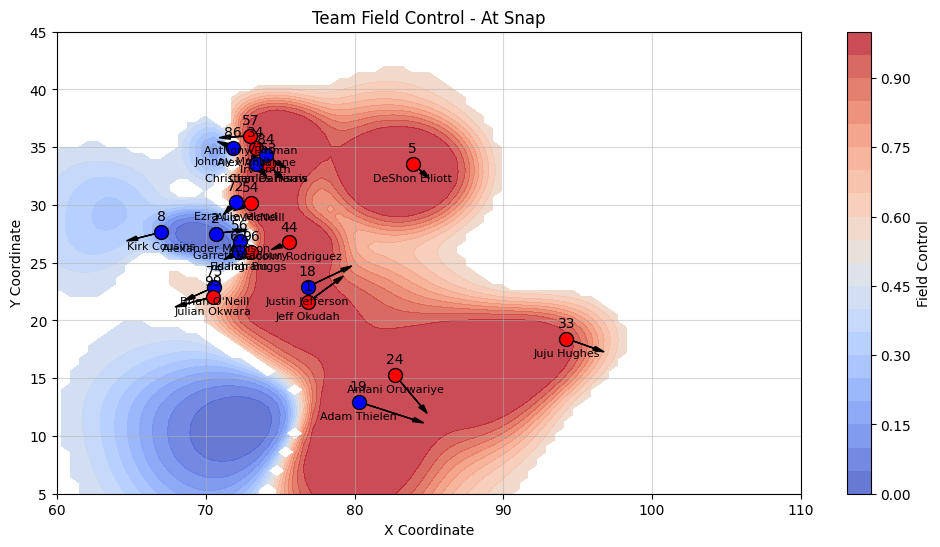

In [72]:
# 1) Make sure densities are numpy arrays and consistent shape
player_df["density"] = player_df["density"].apply(lambda d: np.asarray(d, dtype=float))
ny, nx = player_df["density"].iloc[0].shape  # e.g., (100, 200)

# 2) Build a grid that matches those shapes
x_vals = np.linspace(0.0, 120.0, nx)
y_vals = np.linspace(0.0, 53.3, ny)
X, Y = np.meshgrid(x_vals, y_vals)

# 3) Compute pitch control using cached densities (no model)
player_df2, offense_df, defense_df, pitch_control_df = compute_player_densities_with_pitch_control(
    model=None,
    df=player_df,
    frame_id=140,
    grid=(X, Y),
    use_cached_density=True,
    cache_back_to_df=False
)

# 4) Visualize
visualize_pitch_control_with_players(pitch_control_df, player_df2, frame_id=140)
